# 1. Data Scraping

## 1.1 Scraping Dataset No.1 
> https://www.scotchwhiskyauctions.com/

> with Multi-process and Multi-thread
```python
python3 crawl_auction.py --run crawl --st 0 --ed 10 &
python3 crawl_auction.py --run crawl --st 140 --ed 150 &
```

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import os
import json 
import threading 
import pandas as pd 
from multiprocessing.pool import ThreadPool
import argparse
import numpy as np 
# Define the base URL
BASE_URL = 'https://www.scotchwhiskyauctions.com/'
FILTER_WORD = ['Error 502','Bad Gateway']
KEYS = ['distillery','strength','his_bid_prices','his_bid_times','name','url','auction']
parsed_keys = {'bottle no', 'causeway collection', 'bottle number', 'distiled', 'edition', 'committee release', 'secret distillery #1batch', 'barrel', 'blended', 'ck', 'td-s', 'cask', 'travel exclusive edition', 'farm', 'no', 'easter elchies', 'batch', 'fine oak', 'cask strength', 'creation of a classic', 'rare cask', 'cask toast level', 'recasked', 'edition no', 'catch type', 'appleton', 'single barrel bottle number', 'dumped', 'serial number', "founder's reserve", 'batch number', 'classic cut', 'release number', 'kit number', 'punch bowl', 'barrel number', 'barley type', 'dalbeallie dram no', 'moved to sherry casks', 'bottlled', 'barreled', 'kylver release', 'pact', 'renaissance series no', 'distilled', 'certificate number', 'lot no', 'selection', 'concept no', 'compendium', 'artist no', 'bottled number', 'the renaissance', "master blender's edition", 'the home collection', 'distillery', 'botted', 'small batch', 'harmony collection', '18 year old', "balvenie founder's reserve", 'set number', 'lalique', 'trilogy part', 'the harmony collection', 'no corners to hide', 'cask numbers', 'cask selection', 'please note', 'cask no', 'lot number', 'released', 'edition series', 'feis 2021 release', 'bottles number', 'white stag', "whiskymaker's reserve no", 'cask number', 'cask type', 'home collection', 'single barrel', 'the boutique collection', 'age', 'batch no', 'warehouse', 'casktype', 'barrelled', 'quest collection', 'balvenie doublewood', 'traigh bhan', 'in cask date', 'chichibu', 'bottle numbers', 'tree number', 'winning bid', 'warehouse number', 'selection number', 'bottled', 'mc', 'doublewood', 'dream cask', 'grape', 'botttled', 'solar sytem'}
KEYS = set(KEYS) | parsed_keys
# print(len(KEYS))
fix_keys = ['bidinfo won','lotno']
RUN_MODE = 'crawl'

# {'daftmill', 'dumbarton', 'allt-a-bhainne', 'annandale', 'hanyu', 'longmorn', 'braeval', 'st|magdalene', 'millburn', 'cardhu', 'kininvie', 'ladyburn', 'hakushu', 'yamazaki', 'north|port', 'glenglassaugh', 'miyashita|shuzo', 'glenallachie', 'glenrothes', 'glen|grant', 'glenlivet', 'laphroaig', 'macduff', 'ardnamurchan', 'cameronbridge', 'glasgow', 'blair|athol', 'tormore', 'glenfarclas', 'karuizawa', 'speyburn', 'ballindalloch', 'imperial', 'invergordon', 'glentauchers', 'balmenach', 'ailsa|bay*', 'tobermory', 'glenlochy', 'harris', 'north|of|scotland/strathmore', 'teaninich', 'springbank', 'glen|albyn', 'chichibu', 'bunnahabhain', 'linkwood', 'tullibardine', 'tomatin', 'cragganmore', 'port|ellen', 'north|british', 'scapa', 'glenlossie', 'strathclyde', 'dallas|dhu', 'ardbeg', 'eden|mill', 'white|oak', 'kilchoman', 'knockando', 'glen|elgin', 'lagavulin', 'aberfeldy', 'ardmore', 'lone|wolf', 'carsebridge', 'glendullan', 'dalwhinnie', 'oban', 'fuji|gotemba', 'convalmore', 'lochside', 'tamnavulin', 'dalmunach*', 'glenfiddich', 'miltonduff', 'pulteney', 'bladnoch', 'abhainn|dearg', 'balvenie', 'glen|flagler', 'girvan', 'inverleven', 'mortlach', 'clynelish', 'caledonian', 'yoichi', 'glenury|royal', 'bowmore', 'ben|nevis', 'glen|spey', 'tamdhu', 'torabhaig', 'caol|ila', 'deanston', 'garnheath/moffat', 'strathisla', 'inchdairnie', 'strathearn', 'wolfburn', 'starlaw', 'isle|of|jura', 'inchgower', 'glencadam', 'dailuaine', 'banff', 'fettercairn', 'glen|scotia', 'benrinnes', 'glen|garioch', 'coleburn', 'auchentoshan', 'mannochmore', 'speyside', 'glenesk', 'benromach', 'glen|moray', 'glen|ord', 'auchroisk', 'glendronach', 'glenkinchie', 'aberlour', 'kinclaith', 'edradour', 'bruichladdich', 'arbikie', 'glengyle', 'strathmill', 'glen|keith', 'talisker', 'arran', 'glengoyne', 'littlemill', 'macallan', 'dornoch', 'dufftown', 'glenburgie', 'miyagikyo', 'tomintoul', 'knockdhu', 'highland|park', 'glenmorangie', 'loch|lomond', 'glenugie', 'glenturret', 'dalmore', 'balblair', 'cambus', 'port|dundas', 'rosebank', 'kingsbarns', 'benriach', 'shinshu', 'caperdonich', 'glen|mhor', 'pittyvaich', 'roseisle*', 'aultmore', 'royal|brackla', 'royal|lochnagar', 'brora', 'craigellachie'}

# Define function to get auction details
def get_detailed_pages(base_url:str):
    url = base_url + 'auctions'
    response = requests.get(url)
    assert response.status_code == 200,'network error!'
    
    soup = BeautifulSoup(response.content, 'html.parser')
    items = soup.find_all('div', class_="auctions")[0]
    pages = [base_url + item['href'] for item in items.find_all('a',class_='auction')]
    return pages

def get_sub_pages(auction_url:str):
    if not auction_url.endswith('/'): 
        auction_url+='/'
    response = requests.get(auction_url)
    if response.status_code != 200:
        return []
    soup = BeautifulSoup(response.content, 'html.parser')
    options = soup.find_all('select',{'id':'choosepage'})[0].find_all('option')
    subpages = [auction_url + f'?mode=&page={option.text.split(" ")[1]}' for option in options]
    # subpages = sorted(subpages)
    return subpages

def get_object_pages(sub_page:str):
    response = requests.get(sub_page)
    if response.status_code != 200:
        return []
    soup = BeautifulSoup(response.content, 'html.parser')
    res = soup.find_all('div',{'id':'lots'})[0].find_all('a',class_='lot')
    return [BASE_URL+aval['href'] for aval in res]

def parse_obj(object_page:str):
    info = {}
    response = requests.get(object_page)
    if response.status_code != 200:
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    info['url'] = object_page
    info['name'] = soup.select('#contentstart > h1')[0].text
    lotinfo = soup.find_all('div',class_='lotinfo')[0]
    for pval in lotinfo.find_all('p')[:2]:
        if pval.has_attr('class'):
            info[' '.join(pval['class'])] = pval.text 
    info['details'] = [v.text for v in lotinfo.find('div',class_='descr').find_all('p')] 
    if len(soup.find_all('div',class_='chartwrap'))!=0:
        info['his_bid_times'] = soup.find('input',{'id':'chartx'})['value']
        info['his_bid_prices'] = soup.find('input',{'id':'charty'})['value']
        # print(info)
        # exit(0)
    else:
        info['his_bid_times'] = []
        info['his_bid_prices'] = []
    
    return info 



def parse_json_info(data_dir,dist_names):
    print('start parsing',data_dir)
    file_path = os.path.join('data',f'auctions_{data_dir.split("-")[0].split("/")[-1]}.csv')
    if os.path.isfile(file_path):
        print('has existed for',file_path)
        return 
    all_res = []
    for f in os.listdir(data_dir):
        if not f.endswith('.json'): continue
        org_lst = json.load(open(os.path.join(data_dir,f)))
        for org in org_lst:
            dd = {k: ([] if k=='details' else None) for k in KEYS}
            dd['auction'] = org['url'].split('auctions/')[1].split('/')[0]
            dd['url'] = org['url']
            dd['name'] = org['name']
            dd['his_bid_times'] = [float(v) for v in org['his_bid_times'].split(',')] if len(org['his_bid_times'])!=0 else []
            dd['his_bid_prices'] = [float(v) for v in org['his_bid_prices'].split(',')] if len(org['his_bid_times'])!=0 else []
            dd['url_id'] = int(dd['url'].split('/')[-2 if dd['url'][-1]=='/' else -1].split('-')[0])
            assert len(dd['his_bid_prices']) == len(dd['his_bid_times'])
            for k in fix_keys:
                if k in org:
                    if ': ' not in org[k]: continue 
                    dd[org[k].split(': ')[0]] = org[k].split(': ')[1].replace('\u00a3','')
            words = org['url'].split('-')
            for det in org['details']:
                if ": " in det:
                    kk = det.split(': ')[0].replace('\n',' ').strip().lower()
                    if kk in KEYS:
                        dd[kk] = ': '.join(det.split(': ')[1:])
                if '%' in det and 'cl' in det and '/' in det and len(det.split(' '))<20:
                    dd['strength'] = det
                if 'distillery' in det.lower() and len(det.split(' '))<20 and all([wd in words for wd in det.strip().lower().split()]):
                    dd['distillery'] = det.strip().lower()                    
                    # dd['details'].append(det)
            for k,v in dd.items():
                if v is str and any([wd in v for wd in FILTER_WORD]):
                    dd[k] = None
            all_res.append(dd)
        # break 
    tmpdf = pd.DataFrame(all_res)
    print(tmpdf.shape,len(all_res))
    extract_distillery_from_name(tmpdf,dist_names)
    tmpdf.to_csv(file_path,index=False)
    print('finished parsing',file_path)

def get_cand_cols(data_dir):
    res = set()
    for f in os.listdir(data_dir):
        if not f.endswith('.json'): continue
        org_lst = json.load(open(os.path.join(data_dir,f)))
        for org in org_lst:
            for k in fix_keys + ['details']:
                if k not in org: continue 
                if k == 'details':
                    for v in org[k]:
                        if ': ' in v and len(v.split(' '))<20 and len(v.split(': ')[0].split(' '))<5:
                            kk = v.split(': ')[0].replace('\n',' ').strip().lower()
                            if kk not in res:
                                print(v)
                            res.add(kk)
                elif ': ' in org[k]:
                    kk = org[k].split(': ')[0].lower()
                    if kk not in res:
                        print(org[k])
                    res.add(kk)
                    
        # print(res)
    return res 

def get_dist_names():
	url = 'https://whiskymate.net/the-distillery-list/'
	response = requests.get(url)
	assert response.status_code == 200,'network error!'
	soup = BeautifulSoup(response.content, 'html.parser')
	items = soup.find_all('div', class_="entry-content")[0].find_all('p')
	print(len(items))
	names = set()
	for item in items:
		txt = item.text
		if ') ' in txt and txt.split(') ')[0][0] in [str(i) for i in range(10)] and 'Name' not in txt:
			names.add('|'.join(txt.split(' (')[0].split(') ')[-1].strip().replace('-',' ').lower().split(' ')))
		elif 'Name: ' in txt and ') ' in txt:
			names.add('|'.join(txt.split('Name: ')[-1].strip().replace('-',' ').lower().split(' ')))
	print('collected names len is',len(names))
	return names 

def extract_distillery_from_name(org_csv,dist_names):
	# org_csv = pd.read_csv(file_path)
	org_names = org_csv['name'] #[:100]
	res_dists = [None]*len(org_names)
	for ii,name in enumerate(org_names):
		wds = name.strip(' ').replace('-',' ').lower().split(' ')
		suc = False 
		for i in range(len(wds)):
			for dist in dist_names:
				if wds[i] == dist:
					res_dists[ii] = dist 
					suc = True 
					break 
				elif wds[i] in dist:
					j = i+1
					now_name = wds[i] 
					while j < len(wds):
						now_name = '|'.join([now_name,wds[j]])
						if now_name != dist:
							suc = False 
							break 
						elif now_name == dist:
							res_dists[ii] = now_name
							suc = True
							break 
						else:
							continue
				if suc:
					break 
			if suc: 
				break 
		if suc:
			assert res_dists[ii] is not None, name 
	extra_names = [org_names[i] for i in range(len(res_dists)) if res_dists[i] is None]
	print(len(org_names),len([v for v in res_dists if v is not None]),len(extra_names),len(np.unique([v for v in res_dists if v is not None])))
	# print(res_dists,extra_names,sep='\n')
	org_csv['extracted_distillery'] = res_dists
	# print(org_csv['extracted_distillery'])
	# org_csv.to_csv(file_path.split('.csv')[0]+'_v1'+'.csv')
	return res_dists,extra_names



NEED_DIRS = {90, 91, 92, 119, 120, 141, 142, 143, 144, 151}
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--run',choices=['crawl','parse','ex-name'])
    parser.add_argument('--st',type=int)
    parser.add_argument('--ed',type=int)
    args = parser.parse_args()

    if args.run == 'crawl':
        pages = get_detailed_pages(BASE_URL)[args.st:args.ed]
        # print(sorted([int(pg.split('-')[0].split('/')[-1]) for pg in pages]))
        # exit(0)
        print('the number of auctions are',len(pages),f'from {args.st} to {args.ed}')
        data_dir = './data'
        pool = ThreadPool(20)

        for i,auction_page in enumerate(pages):
            if NEED_DIRS is not None and int(auction_page.split('-')[0].split('/')[-1]) not in NEED_DIRS: continue
            print(f'current auction page is {auction_page}, and progress is {i}:{len(pages)}')
            subpages = get_sub_pages(auction_page)
            print(f'the auction with {len(subpages)} subpages')
            auction_name = auction_page.split('/')[-1] if not auction_page.endswith('/') else auction_page.split('/')[-2]
            # if os.path.exists(os.path.join(data_dir,auction_name)): continue 
            os.makedirs(os.path.join(data_dir,auction_name),exist_ok=True)
            for j,sub_page in enumerate(subpages):
                fname = os.path.join(data_dir,auction_name,f'{j}.json')
                print(fname)
                if os.path.exists(fname): continue
                # if j < args.st or j>= args.ed: continue
                print(f'current sub page progress is {j}:{len(subpages)}')
                object_pages = get_object_pages(sub_page)
                print('object nums of cur page is',len(object_pages))
                infos = [v for v in pool.map(parse_obj,object_pages) if v is not None]
                json.dump(infos,open(fname,'w'),indent=4)
                print('----------')
            # break # only test one auction 
        pool.close()
    elif args.run == 'parse':
        # print(get_cand_cols('data/189-the-144th-auction/'))
        dist_names = json.load(open('dist_names.json','r'))
        dirnames = sorted([v for v in os.listdir('data') if (not v.startswith('.')) and (os.path.isdir(os.path.join('data',v)))])
        print(dirnames)
        for ii,dd in enumerate(dirnames):
            if NEED_DIRS and (int(dd.split('-')[0]) not in NEED_DIRS): continue
            if ii < args.st or ii >= args.ed: continue
            parse_json_info(os.path.join('data',dd),dist_names)

    elif args.run == 'ex-name':
        dist_names = get_dist_names()
        json.dump(list(dist_names),open('dist_names.json','w'))
        dist_names = json.load(open('dist_names.json','r'))
        print(len(dist_names))
    	# print(dist_names)
        extract_distillery_from_name('data/189-the-144th-auction/auctions.csv',dist_names)

## 1.2 Scraping Dataset No.2
> https://whiskyauction.com/

> with Multi-process and Multi-thread 
```python
python3 crawl_auction.py --run crawl --st 0 --ed 10000 &
python3 crawl_auction.py --run crawl --st 480000 --ed 490000 &
```

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import os
import json 
import threading 
import pandas as pd 
from multiprocessing.pool import ThreadPool
import argparse
import numpy as np
# Define the base URL
user_agent = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OSX 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0Safari/537.36',
              "Cookie":'SSESSada4ea5ba2305e4ea206db7f05c8d739=O6y%2C-o9cZhhu1jwNCEnbq%2COnBxCXzT6dXEimznjC6E4IUmwR; cookie-agreed-version=1.0.0; cookie-agreed=2'}
total_num = 490000 # 492268后面都是空的  
KEYS = ['hist_ids','hist_times','hist_prices','hist_codes'] + \
['condition description', 'series', 'ean', 'back label code', 'category', 'alcohol strength', 'packing type', 'addons', 'front label code', 'description', 'auction category', 'bottled for', 'handfilled date', 'age', 'bottom code', 'lot number', 'filling code', 'vp sort description', 'distillery', 'finishing', 'abnumber', 'maturing', 'importer', 'tax banderole code', 'bottler label', 'bottle number', 'distilled date', 'owner', 'name', 'filling level', 'bottled date', 'cask no.', 'content quantity', 'count of bottle', 'brandname', 'release number', 'bottle code', 'whisky type label']
# print(len(KEYS))
POOL_NUM = 20 
DATA_DIR = 'data'
step_len = 300

def get_ids(i:int):
    all_ids = []
    r = requests.post('https://whiskyauction.com/wac/whiskyBrowserData', 
        data={'start':i,'length':step_len,'currentsort':'auction_prose','currentview':'table'},
        headers=user_agent)
    if r.status_code != 200:
        print('error with',str(i))
        return None 
    all_ids += [{'id':dd['id'],'legacy_id':dd['legacy_id'],'item_id':dd['item_id'],'legacy_item_name':dd['legacy_item_name']} for dd in json.loads(r.text)['data']]    
    print('now processing for',i,len(all_ids))
    return all_ids 

def get_all_ids():
    pool = ThreadPool(POOL_NUM)
    i_s = list(np.arange(0,total_num,step_len))
    col_ids = [v for v in pool.map(get_ids,i_s) if v is not None]
    all_ids = []
    for ids in col_ids:
        all_ids += ids 
    print('collected ids num is',len(all_ids))
    pool.close()
    json.dump(sorted(all_ids,key=lambda x:int(x['id'])),open('all_ids.json','w'))

def parse_obj(id:str):
    try:
        r = requests.get(f'https://whiskyauction.com/item/{id}',headers=user_agent)
    except Exception as e:
        print(e)
        return None 
    if r.status_code != 200: return None
    soup = BeautifulSoup(r.content, 'html.parser')
    aa = soup.find('table',class_='detailpage-detaildata')
    data = {}
    data['id'] = id 
    for tr in aa.find_all('tr'):
        v = tr.find_all('td')
        kk = v[0].text.strip().lower().replace(':','')
        vv = v[1].text.strip().lower().replace('\n','')
        data[kk] = vv
    try:
        r = requests.get(f'https://whiskyauction.com/wac/rest/history/{id}?_format=json&action=bh',headers=user_agent)
    except Exception as e:
        print(e)
        return None 
    if r.status_code != 200: return None 
    rr = json.loads(r.text)
    hists = []
    for v in rr['ResultObject']['BottleResults']:
        val = {}
        val['id'] = v['Id']
        val['time'] = v['AuctionNumber']
        val['price'] = v['Result']
        # val['bottlecode'] = v['BottleCode']['BottleCode'] if 'BottleCode' in v else None
        hists.append(val)
    data['hist_ids'] = [v['id'] for v in hists]
    data['hist_times'] = [v['time'] for v in hists]
    data['hist_prices'] = [v['price'] for v in hists]
    # data['hist_codes'] = [v['bottlecode'] for v in hists]
    print('now processing finished for',id)
    # data['history'] = hists
    return data 

def get_key(id:str):
    r = requests.get(f'https://whiskyauction.com/item/{id}',headers=user_agent)
    print(f'https://whiskyauction.com/item/{id}')
    if r.status_code != 200: 
        print(id)
        return None
    soup = BeautifulSoup(r.content, 'html.parser')
    aa = soup.find('table',class_='detailpage-detaildata')
    keys = []
    for tr in aa.find_all('tr'):
        v = tr.find_all('td')
        kk = v[0].text.strip().lower().replace(':','')
        keys.append(kk)

    # data['history'] = hists
    return keys 


def crawl_all(st,ed):
    if os.path.exists(f'data/obj_{st}_{ed}.json'):
        return 
    ids = json.load(open('all_ids.json','r'))
    ids = sorted([int(v['item_id']) for v in ids[st:ed]],reverse=True)
    pool = ThreadPool(POOL_NUM)
    infos = [v for v in pool.map(parse_obj,ids) if v is not None]
    infos = sorted(infos,key=lambda x:int(x['id']))
    print(len(infos))
    json.dump(infos,open(os.path.join(DATA_DIR,f'obj_{st}_{ed}.json'),'w'),indent=4)
    pool.close()


STEP_SIZE = 200 

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--run',choices=['crawl','parse','getids'])
    parser.add_argument('--st',type=int)
    parser.add_argument('--ed',type=int)
    args = parser.parse_args()
   
    if args.run == 'crawl':
        assert (args.ed - args.st) % 200 == 0
        for st in range(args.st,args.ed,STEP_SIZE):
            print('start for',st)
            crawl_all(st,st+STEP_SIZE)
    elif args.run == 'getids':
        # get ids
        get_all_ids()
    elif args.run == 'parse':
        all_recs = []
        fnames = sorted([fname for fname in os.listdir('./data') if (fname.endswith('json') and fname.startswith('obj'))],key=lambda x:int(x.split('_')[1]))[args.st:args.ed]
        print('the number of fnames are',len(fnames))
        for ii,fname in enumerate(fnames):
            print(fname)
            try:
                recs = json.load(open(os.path.join('data',fname),'r'))
            except:
                print('error in read', fname)
                continue
            recs = [{k:(v.replace('\r',' ').replace('\n',' ').strip().lower() if isinstance(v,str) else v) for k,v in rec.items() if 'hist' not in k} for rec in recs]    
            all_recs += recs 
            print(f'now len of recs are {len(all_recs)} for {ii} in {args.ed-args.st}')
        df = pd.DataFrame(all_recs)
        df.to_csv(f'data/data_whiskyauction_{args.st}_{args.ed}.csv',index=False)

        
    
    # get cols 
    # ids = [int(v['item_id']) for v in json.load(open('all_ids.json','r'))]
    # ids = sorted(ids,reverse=True)[:1000]
    # # print(len(ids),len(np.unique(ids)),np.asarray(ids).min(),np.asarray(ids).max(),ids[:100],ids[-100:])
    # all_keys = set()
    # pool = ThreadPool(POOL_NUM)
    # infos = [v for v in pool.map(get_key,ids) if v is not None]
    # for info in infos:
    #     all_keys = all_keys | set(info)
    # pool.close()

# 2. Post Process

## 2.1 Post Process Stage 1 for Dataset No.1
> https://www.scotchwhiskyauctions.com/

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys

%matplotlib inline 

In [277]:
files = sorted(os.listdir('data_csv'))
files = [os.path.join('data_csv',v) for v in files]
print(len(files))

147


In [278]:
cols = pd.read_csv(files[0]).columns
dfs = pd.concat([pd.read_csv(v) for v in files],axis=0,ignore_index=True)
print(dfs.shape)

/var/folders/n2/47w8btw54tj424xjtwbffw3c0000gn/T/ipykernel_87266/132244412.py:2: DtypeWarning: Columns (0,1,4,11,14,19,25,28,31,39,42,54,55,56,58,66,72,73,77,80,93) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.concat([pd.read_csv(v) for v in files],axis=0,ignore_index=True)
/var/folders/n2/47w8btw54tj424xjtwbffw3c0000gn/T/ipykernel_87266/132244412.py:2: DtypeWarning: Columns (4,6,13,40,53,58,74,75,76,83,89,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.concat([pd.read_csv(v) for v in files],axis=0,ignore_index=True)
/var/folders/n2/47w8btw54tj424xjtwbffw3c0000gn/T/ipykernel_87266/132244412.py:2: DtypeWarning: Columns (2,21,25,30,39,49,54,55,62,77,88,91,98,103) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.concat([pd.read_csv(v) for v in files],axis=0,ignore_index=True)
/var/folders/n2/47w8btw54tj424xjtwbffw3c0000gn/T/ipykernel_87266/132244412.py:2: DtypeWarning: Col

(628398, 114)


In [279]:
cols = sorted(dfs.columns)
stats = {}
for cc in cols:
    na_num = dfs[cc].isna().sum()
    nonna_num = dfs[cc].count()
    stats[cc] = round(nonna_num/dfs.shape[0]*100,2)
    print(cc,na_num,nonna_num,f'nonNa ratio: {round(nonna_num/dfs.shape[0]*100,2)}%')

18 year old 627809 589 nonNa ratio: 0.09%
Lot number 0 628398 nonNa ratio: 100.0%
Winning bid 18312 610086 nonNa ratio: 97.09%
age 303063 325335 nonNa ratio: 51.77%
appleton 628397 1 nonNa ratio: 0.0%
artist no 628396 2 nonNa ratio: 0.0%
auction 0 628398 nonNa ratio: 100.0%
balvenie doublewood 628357 41 nonNa ratio: 0.01%
balvenie founder's reserve 628361 37 nonNa ratio: 0.01%
barley type 628324 74 nonNa ratio: 0.01%
barrel 626912 1486 nonNa ratio: 0.24%
barrel number 624883 3515 nonNa ratio: 0.56%
barreled 628281 117 nonNa ratio: 0.02%
barrelled 628285 113 nonNa ratio: 0.02%
batch 625970 2428 nonNa ratio: 0.39%
batch no 627618 780 nonNa ratio: 0.12%
batch number 618156 10242 nonNa ratio: 1.63%
blended 628242 156 nonNa ratio: 0.02%
botted 628396 2 nonNa ratio: 0.0%
bottle no 627998 400 nonNa ratio: 0.06%
bottle number 405434 222964 nonNa ratio: 35.48%
bottle numbers 628294 104 nonNa ratio: 0.02%
bottled 405545 222853 nonNa ratio: 35.46%
bottled number 628178 220 nonNa ratio: 0.04%
bott

In [280]:
sorted_stats_keys = sorted(stats.keys(),key=lambda x:stats[x],reverse=True)
for k in sorted_stats_keys:
    print(k,f'{stats[k]}%')

Lot number 100.0%
auction 100.0%
his_bid_prices 100.0%
his_bid_times 100.0%
name 100.0%
url 100.0%
url_id 100.0%
Winning bid 97.09%
strength 91.57%
extracted_distillery 72.63%
age 51.77%
cask type 39.56%
bottle number 35.48%
bottled 35.46%
distilled 31.33%
cask number 13.96%
batch number 1.63%
dumped 0.61%
barrel number 0.56%
distillery 0.44%
released 0.41%
batch 0.39%
warehouse 0.28%
barrel 0.24%
please note 0.2%
the harmony collection 0.17%
batch no 0.12%
cask 0.12%
18 year old 0.09%
classic cut 0.09%
serial number 0.08%
edition series 0.07%
bottle no 0.06%
cask no 0.06%
committee release 0.05%
travel exclusive edition 0.05%
bottled number 0.04%
bottles number 0.04%
cask numbers 0.04%
lot number 0.03%
barreled 0.02%
barrelled 0.02%
blended 0.02%
bottle numbers 0.02%
cask selection 0.02%
edition 0.02%
edition no 0.02%
lot no 0.02%
quest collection 0.02%
release number 0.02%
warehouse number 0.02%
balvenie doublewood 0.01%
balvenie founder's reserve 0.01%
barley type 0.01%
cask toast l

In [281]:
selected_keys = [k for k in sorted_stats_keys if stats[k]>10.]
print(len(selected_keys),selected_keys)

16 ['Lot number', 'auction', 'his_bid_prices', 'his_bid_times', 'name', 'url', 'url_id', 'Winning bid', 'strength', 'extracted_distillery', 'age', 'cask type', 'bottle number', 'bottled', 'distilled', 'cask number']


In [282]:
dfs_new = dfs[sorted(selected_keys)]
print(dfs_new.shape)

(628398, 16)


In [283]:
dfs_new.head()

,Lot number,Winning bid,age,auction,bottle number,bottled,cask number,cask type,distilled,extracted_distillery,his_bid_prices,his_bid_times,name,strength,url,url_id
0,620119,55,NaN,100-the-62nd-auction,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40% ABV / 70cl,https://www.scotchwhiskyauctions.com/auctions/...,100333
1,621531,55,NaN,100-the-62nd-auction,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40% ABV / 70cl,https://www.scotchwhiskyauctions.com/auctions/...,101847
2,622681,55,NaN,100-the-62nd-auction,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40% ABV / 70cl,https://www.scotchwhiskyauctions.com/auctions/...,103100
3,622979,55,NaN,100-the-62nd-auction,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40% ABV / 70cl,https://www.scotchwhiskyauctions.com/auctions/...,103453
4,622168,720,13 years old,100-the-62nd-auction,NaN,2012,6697,Sherry Butt,1999,macallan,"[860.0, 533.33, 540.0, 590.0, 600.0, 476.67, 5...","[22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29....",Macallan Easter Elchies 2012,57.2% ABV / 70cl,https://www.scotchwhiskyauctions.com/auctions/...,102514


In [ ]:
res_df = dfs_new.copy()

In [348]:
# strength
strength = []
cl_s = []
for v in dfs_new['strength']:
    if v is None or v=='' or str(v)=='nan': 
        strength.append(None)
        cl_s.append(None)
        continue
    tmp = str(v).strip()
    tmp = tmp.replace('\n','').replace(' ','').replace('/','').replace('.%','%').replace('ABV','')
    if '%' in tmp or 'cl' in tmp:
        try:
            # if 'cl' in tmp and re.search('([\d.]+)cl',tmp) is not None:
                # cl = float(re.search('([\d.]+)cl',tmp).groups()[0])
                # if cl < 0.1: 
                    # cl = 70
                # percent = float(re.search('([\d.]+)%',tmp).groups()[0])
                # if percent >= 100 or percent > 100 < 0:
                    # strength.append(None)
                # else:
                # strength.append(/cl)
            # else:
                # strength.append(float(re.search('([\d.]+)%',tmp).grou
            percent = float(re.search('([\d.]+)%',tmp).groups()[0])
            if percent >= 100 or percent < 0:
                strength.append(None)
            else:
                strength.append(percent)
        except:
            print('percent',tmp)
            strength.append(None)
        try:
            cl = float(re.search('([\d.]+)cl',tmp).groups()[0])
            if cl < 0 or cl > 1000:
                cl_s.append(None)
            else:
                cl_s.append(cl)
        except:
            print('cl',tmp)
            cl_s.append(None)
    else:
        print('====',tmp)
        strength.append(None)
        cl_s.append(None)
print(len(strength),len([v for v in strength if v is not None]),dfs_new['strength'].count())
print(len(cl_s),len([v for v in cl_s if v is not None]),dfs_new['strength'].count())
res_df['strength'] = strength
res_df['cl'] = cl_s

cl 58.8%**cl
percent %70cl
percent ??%70cl
percent ???%70cl
percent ????%70cl
percent 58.4.8%70cl
percent ??%75cl
percent **%**cl
cl **%**cl
percent **%20cl
percent 57.8?%70cl
cl 51.5%**cl
cl 58.4%**cl
cl 51.9%**cl
cl 57.2%**cl
percent **%**cl
cl **%**cl
cl 52.8%**cl
percent **%**cl
cl **%**cl
percent ??%70cl
percent 60.5*%70cl
percent **%**cl
cl **%**cl
percent ??%70cl
percent ??%70cl
cl 55.5%75*cl
percent ????%70cl
percent ???%70cl
percent ???%70cl
percent ???%70cl
cl 54.7%**cl
cl 59.3%**cl
percent ??%70cl
percent Nostated%75cl
percent Unstated%2x5cl
cl 55.8%**cl
percent %70cl
percent %70cl
percent ??%70cl
percent Nostated%75cl
percent Unstated%5clx2
percent 51.5*%70cl
percent Nostated%nostatedbottlesizebutapprox70cl
percent Nostated%5cl
cl 43.9%**cl
percent Nostated%Approx.5cl
percent %70cl
percent ????%70cl
percent Nostated%5cl
percent 70°Proof,nostated%5cl
percent ???%70cl
percent Nostated%70cl
percent ??%70cl
cl 46.9%**cl
percent Unstated%2x5cl
cl 51.9%**cl
cl 52.5%**cl
cl 62%**c

In [349]:
print(strength[:100],cl_s[:100])

[40.0, 40.0, 40.0, 40.0, 57.2, 55.3, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, None, None, None, None, 45.8, 45.8, 62.0, 59.9, 57.8, 57.8, 45.8, 45.8, 45.8, 58.1, 57.0, 45.8, None, None, 59.3, 60.0, 45.8, 45.8, 40.0, 40.8, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 52.5, 52.9, 52.7, 55.1, 55.1, None, 35.0, None, 40.0, 40.0, 50.5, 40.0, 46.3, None, 40.0, 43.0, 40.0, 40.0, 46.0, 52.2, 40.0, None, 57.5, 40.0, 40.0, 58.2, 46.0, 46.0, 50.0, 46.0, 61.0, 46.0, 58.5, 58.5, 58.2, 50.0, 50.0, 50.0, 46.0, 46.0, 46.0, 63.5, 59.2, 60.4, 46.0] [70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 75.0, 70.0, 70.0, 70.0, None, None, None, None, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 5.0, None, None, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 5.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, None, 70.0, None, 5.0, 5.0, 5.0, 5.0, 5.

In [329]:
res_df['auction'] = [int(v.split('-')[0]) for v in dfs_new['auction'].astype('str') if v!='' and v!='nan']

In [330]:
ages = []
def is_digital(v:str):
    if len(v) == 0: return False
    for vv in v:
        if not(vv >= '0' and vv <= '9'):
            return False
    return True

for v in dfs_new['age'].astype(str):
    if v == 'nan': 
        ages.append(None)
        continue
    v = v.strip().lower()
    if 'old' in v or 'year' in v:
        try:
            ages.append(int(re.search('(\d+)',v).groups()[0]))
        except:
            if 'one' in v: ages.append(1)
            elif 'two' in v: ages.append(2)
            elif 'three' in v: ages.append(3)
            elif 'four' in v: ages.append(4)
            else:
                print(v)
                ages.append(None)
    elif 'hour' in v:
        v = v.replace(',','')
        ages.append(int(v.split(' ')[0])/(24*365))
    elif 'month' in v:
        v = v.replace(',','')
        try:
            ages.append(int(v.split(' month')[0].split(' ')[-1].split('-')[0])/12)
        except:
            print(v)
            ages.append(None)
    elif 'day' in v:
        v = v.replace(',','')
        ages.append(int(v.split('day')[0].strip().split(' ')[-1])/365)
    elif '.' in v:
        v = v.split('.')[-1]
        if is_digital(v):
            ages.append(int(v))
        else:
            ages.append(None)
            print('===',v)
    else:
        v = v.replace(',',' ').split(' ')[0]
        if is_digital(v):
            ages.append(int(v))
        else:
            print('---',v)
            ages.append(None)
print(len(ages),len([v for v in ages if v is not None]),dfs_new['age'].count())

--- xo
--- refill
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- ????
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- bourbon
--- bourbon
--- unknown
& years old
--- xo
--- xo
--- ???
--- first
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- xo
--- vsop
--- xo
--- xo
--- xo
--- ??????
--- xo
not very old
=== 
--- refill
--- august
--- xo
--- refill
--- non
& years old
--- xo
--- non
--- ripped
=== 
--- 19cask
--- 45%abv
--- vsop
--- 46%abv
--- refill
--- nas
--- nas
--- xo
--- refill
--- xo
628398 325264 325335


In [331]:
res_df['age'] = ages

In [332]:
dfs_new['bottle number'].count()

222964

In [333]:
bot_numbers = []
for org in dfs_new['bottle number'].astype(str):
    if org == 'nan':
        bot_numbers.append(None)
        continue
    v = org.lower().strip()
    if '/' in v:
        vvv = '/'.join(v.split('/')[1:]).strip()
        if re.search('(\d+)',vvv) is not None:
            v = vvv
    elif 'of' in v:
        vvv = 'of'.join(v.split('of')[1:]).strip()
        if re.search('(\d+)',vvv) is not None:
            v = vvv
    # x = v.split(' ')[0].replace(',','')
    # if is_digital(x):
    #     x = int(x)
    # else:
    #     print('===',x)
    #     continue
    search_res = re.search('(\d+)',v)
    if search_res is not None:
        res = search_res.groups()
        if len(res) == 1:
            y = int(res[0])
            bot_numbers.append(y)
        else:
            print('=======')
    else:
        # print('---',org)
        bot_numbers.append(None)
    # bot_numbers.append(x/y)
print(len(bot_numbers),len([v for v in bot_numbers if v is not None]),dfs_new['bottle number'].count())

628398 222860 222964


In [334]:
res_df['bottle number'] = bot_numbers

In [335]:
bottled = []
years = [str(i) for i in np.arange(1800,2030)]
for org in dfs_new['bottled'].astype(str):
    if org == 'nan':
        bottled.append(None)
        continue
    v = org.lower().strip()
    found = False
    for year in years:
        if year in v:
            bottled.append(int(year))
            found = True
            break
    if found: continue
    vv = -1
    try:
        if '/' in v:
            vv = int(v.split('/')[-1].strip().split(' ')[0])
        elif '.' in v:
            if v.endswith('.'): v=v[:-1] 
            vv = int(v.split('.')[-1].strip().split(' ')[0])
        else:
            vv = int(v.split(' ')[-1].strip()[0])
    except:
        pass
    if vv < 0 or vv > 99:
        print('-----',org)
        bottled.append(None)
    else:
        tmp = int(2000+vv)
        if tmp > 2020: tmp -= 100
        bottled.append(tmp)
# without process 

----- 79 / 250
----- ????
----- 26.02.200
----- No information
----- ?
----- No information
----- No information
----- ????
----- February
----- 08.09.200
----- February
----- 20.08.200
----- August
----- ?????
----- ???
----- ???
----- 23 years old
----- 08 43% ABV / 10cl
----- ????
----- ???
----- Autumn 
----- 22.02.1028
----- 512 / 615
----- 09.09.209
----- ?????
----- ????
----- December
----- 25.03.201 
----- 29.09.2918
----- 14.11.204
----- 10.11.2917
----- 03.09.2107
----- 26.09.2918
----- ****
----- 2458 / 6080
----- 18.05.205
----- 05.08.209
----- 09.211
----- September
----- September
----- 14.11.204
----- 14.11.204
----- 05.08.209
----- September 
----- December 10 Year Old 
----- 14.11.204
----- September 
----- ****
----- December 10 Year Old 
----- 10.206
----- 12.05.3005
----- ??????
----- ????
----- 16.07.??
----- 12 Years Old 
----- 04.03.0214
----- 14.11.204
----- 52 / 160
----- 14.11.204
----- December 10 Year Old 
----- One of only 23000 bottles released
----- Sept

In [336]:
print(len(bottled),len([v for v in bottled if v is not None]),dfs_new['bottled'].count())

628398 222717 222853


In [337]:
res_df['bottled'] = bottled

In [338]:
bids = [None if v=='nan' else float(v.replace(',','')) for v in res_df['Winning bid'].astype(str)]

In [339]:
res_df['Winning bid'] = bids

In [340]:
cask_numbers = []
for org in dfs_new['cask number'].astype(str):
    if org == 'nan':
        cask_numbers.append(None)
        continue
    v = org.lower().strip()
    if '/' in v:
        vvv = '/'.join(v.split('/')[1:]).strip()
        if re.search('(\d+)',vvv) is not None:
            v = vvv
    elif 'of' in v:
        vvv = 'of'.join(v.split('of')[1:]).strip()
        if re.search('(\d+)',vvv) is not None:
            v = vvv
    # x = v.split(' ')[0].replace(',','')
    # if is_digital(x):
    #     x = int(x)
    # else:
    #     print('===',x)
    #     continue
    search_res = re.search('(\d+)',v)
    if search_res is not None:
        res = search_res.groups()
        if len(res) == 1:
            y = int(res[0])
            cask_numbers.append(y)
        else:
            print('=======')
    else:
        # print('---',org)
        cask_numbers.append(None)
    # bot_numbers.append(x/y)
print(len(cask_numbers),len([v for v in cask_numbers if v is not None]),dfs_new['cask number'].count())

628398 87557 87736


In [341]:
res_df['cask number'] = cask_numbers

In [342]:
distilled = []
years = [str(i) for i in np.arange(1800,2030)]
for org in dfs_new['distilled'].astype(str):
    if org == 'nan':
        distilled.append(None)
        continue    
    v = org.lower().replace('\n',' ').strip()
    found = False
    for year in years:
        if year in v:
            distilled.append(int(year))
            found = True
            break
    if found: continue
    vv = -1
    if 'Bottled' in org: 
        v = v.split(' ')[0]
    if v.endswith('.'): v=v[:-1] 
    try:
        if '.' in v:
            vv = int(v.split('.')[-1].strip().split(' ')[0])
        elif '/' in v:
            vv = int(v.split('/')[-1].strip().split(' ')[0])
        else:
            vv = int(v.split(' ')[-1].strip()[0])
    except:
        pass
    if vv < 0 or vv > 99:
        # if 'Bottled' in org:
        print('-----',org)
        distilled.append(None)
    else:
        tmp = int(2000+vv)
        if tmp > 2020: tmp -= 100
        distilled.append(tmp)
print(len(distilled),len([v for v in distilled if v is not None]),dfs_new['distilled'].count())

----- 03.09.1196
-----  
----- 14.09.0983
----- 24.03.199 
----- 13.07.995
----- 13.07.995
----- 27.02.1668
----- 27.08.1079
----- 25.09.207
----- 16.01.2079
----- 03.975
----- 03.975
----- 18.04.200
----- ??.??.????
----- 14.09.0983
----- 11.03.205
----- 17.10.201
----- 13 Years Old 
----- 17.10.201
----- 08.1075
----- 28.05.2984
----- 17.10.201
----- ??.??.????
----- 09.196 
----- 04.965
----- ??.??.????
----- ****
----- 24.10.201
----- Raasay
----- 17.10.201
----- 09.996
----- 20.12.207
----- 20.12.207
----- 1.07.208
----- 03.08.200
----- 14.09.0983
----- 31.05.2099
----- 17.10.201
----- 1.07.208
----- 25.11.0982
----- 1.09.0980
----- 29/03/99, bottled: 12/06/08. 70cl and 46%. Bottle no 15 of 480
----- 20th November
----- at Tomatin
----- Winter Distillation
----- 11.09.01, 
----- 2nd June
----- Multiple dates 
----- 19.04.991
----- 18/01/199
628398 196830 196880


In [343]:
res_df['distilled'] = distilled

In [350]:
for col in res_df.columns:
    print(col,res_df[col].dtype)

Lot number object
Winning bid float64
age float64
auction object
bottle number float64
bottled float64
cask number float64
cask type object
distilled float64
extracted_distillery object
his_bid_prices object
his_bid_times object
name object
strength float64
url object
url_id object
cl float64


In [351]:
res_df['url_id'] = res_df['url_id'].astype(str)
res_df['auction'] = res_df['auction'].astype(str)

In [352]:
res_df.describe().round(2)

,Winning bid,age,bottle number,bottled,cask number,distilled,strength,cl
count,610086.00,325264.00,2.228600e+05,222717.00,8.755700e+04,196830.00,575225.00,575304.00
mean,243.67,17.08,1.613764e+04,2014.03,1.188040e+07,1994.89,48.91,66.69
std,843.29,25.65,1.640155e+06,7.36,1.622643e+09,12.93,7.10,14.36
min,5.00,0.00,0.000000e+00,1812.00,0.000000e+00,1805.00,0.30,0.00
25%,55.00,12.00,2.320000e+02,2011.00,4.170000e+02,1989.00,43.00,70.00
50%,100.00,15.00,4.800000e+02,2016.00,2.363000e+03,1997.00,47.50,70.00
75%,210.00,21.00,1.742000e+03,2019.00,9.000000e+03,2005.00,55.00,70.00
max,200000.00,5000.00,6.347312e+08,2026.00,4.612000e+11,2029.00,90.00,780.00


In [353]:
cols = sorted(res_df.columns)
stats = {}
for cc in cols:
    na_num = res_df[cc].isna().sum()
    nonna_num = res_df[cc].count()
    stats[cc] = round(nonna_num/res_df.shape[0]*100,2)
    print(cc,f'nonNa ratio: {round(nonna_num/res_df.shape[0]*100,2)}% and #na is {na_num}, #nonna is {nonna_num}')

Lot number nonNa ratio: 100.0% and #na is 0, #nonna is 628398
Winning bid nonNa ratio: 97.09% and #na is 18312, #nonna is 610086
age nonNa ratio: 51.76% and #na is 303134, #nonna is 325264
auction nonNa ratio: 100.0% and #na is 0, #nonna is 628398
bottle number nonNa ratio: 35.46% and #na is 405538, #nonna is 222860
bottled nonNa ratio: 35.44% and #na is 405681, #nonna is 222717
cask number nonNa ratio: 13.93% and #na is 540841, #nonna is 87557
cask type nonNa ratio: 39.56% and #na is 379820, #nonna is 248578
cl nonNa ratio: 91.55% and #na is 53094, #nonna is 575304
distilled nonNa ratio: 31.32% and #na is 431568, #nonna is 196830
extracted_distillery nonNa ratio: 72.63% and #na is 171963, #nonna is 456435
his_bid_prices nonNa ratio: 100.0% and #na is 0, #nonna is 628398
his_bid_times nonNa ratio: 100.0% and #na is 0, #nonna is 628398
name nonNa ratio: 100.0% and #na is 0, #nonna is 628398
strength nonNa ratio: 91.54% and #na is 53173, #nonna is 575225
url nonNa ratio: 100.0% and #na i

In [354]:
res_df.to_csv('datas/total_data_v1_0707.csv',index=False)

## 2.2 Post Process Stage1.2 for Dataset No.1

In [373]:
df = pd.read_csv('datas/total_data_v1_0707.csv',low_memory=False)
print(df.shape)
print(df.columns)
df.head(10)

(628398, 17)
Index(['Lot number', 'Winning bid', 'age', 'auction', 'bottle number',
       'bottled', 'cask number', 'cask type', 'distilled',
       'extracted_distillery', 'his_bid_prices', 'his_bid_times', 'name',
       'strength', 'url', 'url_id', 'cl'],
      dtype='object')


,Lot number,Winning bid,age,auction,bottle number,bottled,cask number,cask type,distilled,extracted_distillery,his_bid_prices,his_bid_times,name,strength,url,url_id,cl
0,620119,55.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40.0,https://www.scotchwhiskyauctions.com/auctions/...,100333,70.0
1,621531,55.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40.0,https://www.scotchwhiskyauctions.com/auctions/...,101847,70.0
2,622681,55.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40.0,https://www.scotchwhiskyauctions.com/auctions/...,103100,70.0
3,622979,55.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....",Macallan Director's Edition,40.0,https://www.scotchwhiskyauctions.com/auctions/...,103453,70.0
4,622168,720.0,13.0,100,NaN,2012.0,6697.0,Sherry Butt,1999.0,macallan,"[860.0, 533.33, 540.0, 590.0, 600.0, 476.67, 5...","[22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29....",Macallan Easter Elchies 2012,57.2,https://www.scotchwhiskyauctions.com/auctions/...,102514,70.0
5,622169,720.0,17.0,100,NaN,2013.0,26.0,Sherry Butt,1996.0,macallan,"[540.0, 506.67, 615.0, 580.0, 620.0, 566.67, 5...","[33.0, 34.0, 36.0, 37.0, 43.0, 44.0, 45.0, 49....",Macallan Easter Elchies 2013,55.3,https://www.scotchwhiskyauctions.com/auctions/...,102515,70.0
6,620009,90.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[165.0, 180.0, 111.67, 108.89, 67.78, 95.83, 7...","[57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64....",Macallan Edition No1,48.0,https://www.scotchwhiskyauctions.com/auctions/...,95219,70.0
7,620008,95.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[165.0, 180.0, 111.67, 108.89, 67.78, 95.83, 7...","[57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64....",Macallan Edition No1,48.0,https://www.scotchwhiskyauctions.com/auctions/...,95218,70.0
8,620010,95.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[165.0, 180.0, 111.67, 108.89, 67.78, 95.83, 7...","[57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64....",Macallan Edition No1,48.0,https://www.scotchwhiskyauctions.com/auctions/...,95220,70.0
9,620302,95.0,NaN,100,NaN,NaN,NaN,NaN,NaN,macallan,"[165.0, 180.0, 111.67, 108.89, 67.78, 95.83, 7...","[57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64....",Macallan Edition No1,48.0,https://www.scotchwhiskyauctions.com/auctions/...,100608,70.0


In [374]:
from collections import Counter 
stats = Counter(df['url_id'].astype(str))
dup_keys = []
dup_vs = []
for k,v in stats.items():
    if v > 1:
        dup_keys.append(k)
        dup_vs.append(v)
        # print(k,v)
print(len(dup_keys),dup_keys[:5])
print(np.unique(dup_vs))

1968 ['102790', '103002', '101169', '100585', '103225']
[2 3 4 5 6]


In [375]:
# remove duplicate datas 
newdf = df.drop_duplicates('url',keep='first')
print(newdf.shape)
newdf = newdf.drop_duplicates('his_bid_prices',keep='first')
print(newdf.shape)

(626285, 17)
(30548, 17)


In [376]:
cols = sorted(newdf.columns)
stats = {}
for cc in cols:
    na_num = newdf[cc].isna().sum()
    nonna_num = newdf[cc].count()
    stats[cc] = round(nonna_num/newdf.shape[0]*100,2)
    print(cc,f'nonNa ratio: {round(nonna_num/newdf.shape[0]*100,2)}% and #na is {na_num}, #nonna is {nonna_num}')

Lot number nonNa ratio: 100.0% and #na is 0, #nonna is 30548
Winning bid nonNa ratio: 98.34% and #na is 507, #nonna is 30041
age nonNa ratio: 57.39% and #na is 13015, #nonna is 17533
auction nonNa ratio: 100.0% and #na is 0, #nonna is 30548
bottle number nonNa ratio: 48.6% and #na is 15702, #nonna is 14846
bottled nonNa ratio: 44.38% and #na is 16990, #nonna is 13558
cask number nonNa ratio: 24.96% and #na is 22922, #nonna is 7626
cask type nonNa ratio: 43.55% and #na is 17244, #nonna is 13304
cl nonNa ratio: 91.26% and #na is 2671, #nonna is 27877
distilled nonNa ratio: 49.33% and #na is 15478, #nonna is 15070
extracted_distillery nonNa ratio: 71.35% and #na is 8753, #nonna is 21795
his_bid_prices nonNa ratio: 100.0% and #na is 0, #nonna is 30548
his_bid_times nonNa ratio: 100.0% and #na is 0, #nonna is 30548
name nonNa ratio: 100.0% and #na is 0, #nonna is 30548
strength nonNa ratio: 91.26% and #na is 2670, #nonna is 27878
url nonNa ratio: 100.0% and #na is 0, #nonna is 30548
url_id 

In [377]:
print(np.sum(newdf['bottled'].notna().values),
np.sum(newdf['distilled'].notna().values))
with_val = newdf['distilled'].notna().values & newdf['bottled'].notna().values
np.sum(with_val)

13558 15070


11322

In [378]:
need_fill = newdf['age'].isna().values & with_val
print(np.sum(newdf['age'].notna().values),np.sum(need_fill))

17533 3649


In [379]:
newdf[need_fill]['bottled'].min(),newdf[need_fill]['bottled'].max(), newdf[need_fill]['distilled'].min(),newdf[need_fill]['distilled'].max()

(1974.0, 2023.0, 1900.0, 2019.0)

In [380]:
newdf.loc[need_fill,'age'] = newdf[need_fill]['bottled'].values - newdf[need_fill]['distilled'].values

In [381]:
print(np.sum(newdf['age'].notna().values))

21182


In [382]:
newdf = newdf.drop(columns=['Lot number'])

In [383]:
np.percentile(newdf[newdf['age'].notna()]['age'],range(0,105,5))

array([  -3.,    7.,    9.,   10.,   11.,   12.,   12.,   13.,   14.,
         15.,   17.,   18.,   19.,   21.,   22.,   24.,   25.,   28.,
         30.,   36., 2022.])

In [384]:
newdf['his_bid_prices'] = [v[1:-1].split(', ') if v[1:-1].split(', ')[0]!='' else None  for v in newdf['his_bid_prices']]
print(newdf.shape)
newdf = newdf.dropna('index',subset=['his_bid_prices'])
print(newdf.shape)

(30548, 16)
(30547, 16)


In [385]:
newdf['Winning bid'] = [float(v[-1]) for v in newdf['his_bid_prices']]

In [386]:
np.percentile(newdf[newdf['Winning bid'].notna()]['Winning bid'],range(0,105,5))

array([5.000e+00, 3.000e+01, 4.000e+01, 4.667e+01, 5.500e+01, 6.500e+01,
       7.500e+01, 8.500e+01, 9.500e+01, 1.100e+02, 1.300e+02, 1.500e+02,
       1.700e+02, 2.000e+02, 2.500e+02, 3.000e+02, 4.000e+02, 5.200e+02,
       8.000e+02, 1.500e+03, 7.800e+04])

In [387]:
newdf = newdf[True ^ (newdf['age']<0)]
newdf = newdf[True ^ (newdf['age']>300)]
newdf = newdf[True ^ (newdf['Winning bid']>10000)]
print(newdf.shape)

(30453, 16)


In [388]:
import requests
import re
from bs4 import BeautifulSoup
import json 

In [389]:
np.unique(newdf['auction'])

array([ 14,  15,  18,  23,  27,  29,  30,  31,  33,  34,  37,  38,  39,
        40,  43,  44,  45,  46,  47,  48,  49,  50,  51,  53,  55,  56,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  79,  80,  81,  84,  85,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 169, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188,
       189, 190])

In [390]:
newdf['his_bid_times'] = [v[1:-1].split(', ') if v[1:-1].split(', ')[0]!='' else None for v in newdf['his_bid_times']]
newdf['auction'] = [round(float(v[-1])) for v in newdf['his_bid_times'] if v is not None]
print(newdf.loc[:3,['his_bid_times','auction']])

                                       his_bid_times  auction
0  [24.0, 25.0, 26.0, 28.0, 29.0, 31.0, 33.0, 34....      143


In [391]:
auc_to_date = {}
resp = requests.get('https://www.scotchwhiskyauctions.com/auctions/')
if resp.status_code != 200:
    assert False
soup = BeautifulSoup(resp.content,'html.parser')
aa = soup.find('div',class_='auctions').find_all('a',class_='auction')

last = 100000
for val in aa:
    if 'charity' in val.get('href'):
        continue
    if last <= 10:
        auc = last - 1
    else:
        auc = int(val.get('href').split('/')[1].split('-auction')[0].split('-')[-1][:-2])
    last = auc
    for v in val.text.strip().split(' ')[1:-2]:
        if 'There' in v: 
            year = int(v[:4])
    auc_to_date[auc] = year
print(auc_to_date)
print(len(auc_to_date))
# print(np.min(auc_to_date.keys()),np.max(auc_to_date.keys()))

{146: 2023, 145: 2023, 144: 2023, 143: 2023, 142: 2023, 141: 2023, 140: 2023, 139: 2023, 138: 2022, 137: 2022, 136: 2022, 135: 2022, 134: 2022, 133: 2022, 132: 2022, 131: 2022, 130: 2022, 129: 2022, 128: 2022, 127: 2022, 126: 2021, 125: 2021, 124: 2021, 123: 2021, 122: 2021, 121: 2021, 120: 2021, 119: 2021, 118: 2021, 117: 2021, 116: 2021, 115: 2021, 114: 2020, 113: 2020, 112: 2020, 111: 2020, 110: 2020, 109: 2020, 108: 2020, 107: 2020, 106: 2020, 105: 2020, 104: 2019, 103: 2019, 102: 2019, 101: 2019, 100: 2019, 99: 2019, 98: 2019, 97: 2019, 96: 2019, 95: 2019, 94: 2019, 93: 2019, 92: 2018, 91: 2018, 90: 2018, 89: 2018, 88: 2018, 87: 2018, 86: 2018, 85: 2018, 84: 2018, 83: 2018, 82: 2018, 81: 2018, 80: 2017, 79: 2017, 78: 2017, 77: 2017, 76: 2017, 75: 2017, 74: 2017, 73: 2017, 72: 2017, 71: 2017, 70: 2017, 69: 2017, 68: 2016, 67: 2016, 66: 2016, 65: 2016, 64: 2016, 63: 2016, 62: 2016, 61: 2016, 60: 2016, 59: 2016, 58: 2016, 57: 2016, 56: 2015, 55: 2015, 54: 2015, 53: 2015, 52: 2015, 51

In [ ]:
newdf['auc_year'] = [auc_to_date[v] for v in newdf['auction'].astype(np.int32)]

In [394]:
newdf['his_bid_times'] = [[str(auc_to_date[round(float(vv))]) for vv in v] for v in newdf['his_bid_times']]

In [395]:
np.percentile(newdf[newdf['auc_year'].notna()]['auc_year'],range(0,105,5))

array([2011., 2016., 2016., 2017., 2018., 2019., 2020., 2020., 2021.,
       2021., 2022., 2022., 2022., 2022., 2022., 2023., 2023., 2023.,
       2023., 2023., 2023.])

In [398]:
newdf = newdf.drop(columns=['auction','url','url_id','name'])
print(newdf.shape)
print(list(newdf.columns))

(30453, 13)
['Winning bid', 'age', 'bottle number', 'bottled', 'cask number', 'cask type', 'distilled', 'extracted_distillery', 'his_bid_prices', 'his_bid_times', 'strength', 'cl', 'auc_year']


In [399]:
a_cat_cols = ['cask type','extracted_distillery']
a_cat_dict = {c:{} for c in a_cat_cols}
for k in a_cat_cols:
    uniq_vals = np.sort(np.unique(newdf[k].astype(str)))
    print(k,len(uniq_vals))
    a_cat_dict[k] = {k:i for i,k in enumerate(uniq_vals)}
print(a_cat_dict.keys())
for k,v in a_cat_dict.items(): print(k,len(v))

cask type 3339
extracted_distillery 154
dict_keys(['cask type', 'extracted_distillery'])
cask type 3339
extracted_distillery 154


In [400]:
for k in a_cat_cols:
    newdf[k] = [a_cat_dict[k][v] if v not in ['nan','none'] else None for v in newdf[k].astype(str)]

In [401]:
newdf.head()

,Winning bid,age,bottle number,bottled,cask number,cask type,distilled,extracted_distillery,his_bid_prices,his_bid_times,strength,cl,auc_year
0,270.00,NaN,NaN,NaN,NaN,NaN,NaN,111.0,"[130.0, 88.33, 61.0, 47.5, 48.33, 45.0, 43.75,...","[2013, 2013, 2013, 2013, 2013, 2013, 2014, 201...",40.0,70.0,2023
4,2600.00,13.0,NaN,2012.0,6697.0,2979.0,1999.0,111.0,"[860.0, 533.33, 540.0, 590.0, 600.0, 476.67, 5...","[2013, 2013, 2013, 2013, 2013, 2013, 2013, 201...",57.2,70.0,2023
5,3200.00,17.0,NaN,2013.0,26.0,2979.0,1996.0,111.0,"[540.0, 506.67, 615.0, 580.0, 620.0, 566.67, 5...","[2014, 2014, 2014, 2014, 2014, 2014, 2015, 201...",55.3,70.0,2023
6,1241.67,NaN,NaN,NaN,NaN,NaN,NaN,111.0,"[165.0, 180.0, 111.67, 108.89, 67.78, 95.83, 7...","[2016, 2016, 2016, 2016, 2016, 2016, 2016, 201...",48.0,70.0,2023
12,1500.00,NaN,NaN,NaN,NaN,NaN,NaN,111.0,"[145.0, 65.0, 90.0, 115.0, 85.0, 140.0, 145.0,...","[2016, 2016, 2016, 2016, 2016, 2016, 2016, 201...",48.0,75.0,2023


In [402]:
newdf['his_bid_prices'] = [','.join(v) for v in newdf['his_bid_prices']]
newdf['his_bid_times'] = [','.join(v) for v in newdf['his_bid_times']]

In [403]:
newdf.to_csv('datas/d_p1_stage1.csv',index=False)

## 2.3 Post Process Stage 1 for Dataset No.2
> https://whiskyauction.com/wac/whiskyBrowserData

In [293]:
df = pd.read_csv('datas/all_data_org.csv',lineterminator='\n',low_memory=False)
print(df.shape)
print(list(df.columns))

(473638, 47)
['id', 'distillery', 'name', 'bottler label', 'distilled date', 'bottled date', 'age', 'whisky type label', 'description', 'packing type', 'alcohol strength', 'content quantity', 'ean', 'bottle code', 'legacy item name', 'category', 'hist_ids', 'hist_times', 'hist_prices', 'series', 'cask no.', 'maturing', 'count of bottle', 'bottled for', 'bottle number', 'brandname', 'release number', 'filling code', 'finishing', 'condition description', 'bottom code', 'front label code', 'back label code', 'importer', 'vp sort description', 'accessoires type', 'size', 'handfilled date', 'filling level', 'owner', 'addons', 'tax banderole code', 'code', 'auction category', 'abnumber', 'lot number', 'symbols']


In [294]:
notna_num_dict = {k:df[k].notna().sum()/df.shape[0] for k in df.columns}
sorted_keys = sorted(notna_num_dict.keys(),key=lambda x:notna_num_dict[x],reverse=True)
for k in sorted_keys:
    print(k,round(notna_num_dict[k],2))

id 1.0
category 1.0
hist_ids 1.0
hist_times 1.0
hist_prices 1.0
packing type 0.95
content quantity 0.94
alcohol strength 0.94
whisky type label 0.93
legacy item name 0.84
bottler label 0.76
distillery 0.75
age 0.55
ean 0.54
distilled date 0.39
description 0.37
bottled date 0.37
maturing 0.29
count of bottle 0.28
name 0.28
brandname 0.28
series 0.24
bottle code 0.24
cask no. 0.2
bottle number 0.19
auction category 0.16
filling code 0.11
release number 0.11
lot number 0.1
bottom code 0.08
owner 0.08
condition description 0.08
bottled for 0.07
finishing 0.06
accessoires type 0.05
size 0.05
abnumber 0.05
importer 0.04
tax banderole code 0.04
filling level 0.02
back label code 0.02
front label code 0.02
vp sort description 0.01
code 0.01
addons 0.0
handfilled date 0.0
symbols 0.0


In [325]:
newdf = df.drop_duplicates('hist_prices',keep='first')
print(newdf.shape)

(81753, 47)


In [326]:
newdf = newdf.drop(columns=['bottle number','cask no.'])

In [327]:
need_cols = ['Lot number', 'auction', 'url', 'name']

col_name_map = {'hist_prices':'his_bid_prices', 
             'hist_times':'his_bid_times',
             'id':'url_id',
             'price':'Winning bid', 
             'alcohol strength':'strength',
             'distillery':'extracted_distillery',
             'age':'age',
             'packing type': 'cask type', 
             'count of bottle': 'bottle number', 
             'bottled date': 'bottled', 
             'distilled date':'distilled',
             'content quantity':'cl'}
             # 'cask no.':'cask number'}

In [328]:
newdf = newdf[[k for k in newdf.columns if notna_num_dict[k]>0.18]]
print(newdf.shape)

(81753, 23)


In [329]:
ht = [[v[1:-1] for v in val[1:-1].split(', ')] for val in newdf['hist_times']]
hp = [[v[1:-1] for v in val[1:-1].split(', ')] for val in newdf['hist_prices']]
hi = [[v[1:-1] for v in val[1:-1].split(', ')] for val in newdf['hist_ids']]
print(len(ht),ht[0],hp[0],hi[0])

81753 ['2023-06', '2023-05', '2023-05', '2023-04', '2023-04', '2023-03', '2023-03', '2022-11', '2022-10', '2022-09', '2022-09', '2022-06', '2022-02', '2022-01', '2022-01', '2022-01', '2022-01', '2021-11', '2021-11', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-07', '2021-07', '2021-06', '2021-05', '2021-05', '2021-05', '2021-01', '2021-01', '2020-12', '2020-12', '2020-12', '2020-11', '2020-11', '2020-06', '2020-05', '2020-04', '2020-03', '2019-12', '2019-11', '2019-11', '2019-09', '2019-07', '2019-03'] ['400', '450', '470', '472', '478', '490', '480', '475', '481', '486', '495', '512', '445', '495', '450', '456', '456', '415', '416', '410', '455', '516', '521', '530', '435', '445', '605', '470', '480', '475', '439', '505', '436', '448', '436', '410', '410', '475', '420', '407', '421', '355', '395', '396', '435', '366', '449'] ['2116992', '2040078', '2040087', '1970723', '1970732', '1901882', '1901891', '1615851', '1428210', '1428219', '1393216', '1360845', '1321015', '1

In [330]:
newdf['hist_prices'] = hp
newdf['hist_times'] = ht
newdf['hist_ids'] = hi

In [331]:
import re
import json

In [332]:
cols = []
for v in newdf['content quantity'].astype(str):
    if v == 'nan': 
        cols.append(None)
        continue
    try:
        val = re.search('(\d[\d\.]*)',v).groups()[0]
        if val.startswith('.'): val = val[1:]
        if val.endswith('.'): val = val[:-1]
        cols.append(float(val))
    except:
        # print(v)
        cols.append(None)
print(len(cols),cols[0])

81753 70.0


In [333]:
strengths = []
for v in newdf['alcohol strength'].astype(str):
    if v == 'nan': 
        strengths.append(None)
        continue
    try:
        val = re.search('(\d[\d\.]*)',v).groups()[0]
        if val.startswith('.'): val = val[1:]
        if val.endswith('.'): val = val[:-1]
        strengths.append(float(val))
    except:
        strengths.append(None)
print(len(strengths),strengths[0])

81753 46.4


In [334]:
newdf['content quantity'] = cols
newdf['alcohol strength'] = strengths

In [335]:
ages = []
for v in newdf['age'].astype(str):
    if v == 'nan':
        ages.append(None)
        continue
    try:
        ages.append(float(v))
    except:
        try:
            v = v.replace(' ','')
            yy,mm=0,0
            if 'year' not in v and 'month' not in v:
                ages.append(None)
                continue
            if 'year' in v:
                yy = float(re.search('(\d+)',v.split('year')[0]).groups()[0])
            if 'month' in v:
                mm = float(re.search('(\d+)',v.split('month')[0]).groups()[0])
            ages.append(yy+mm/12) 
        except:
            ages.append(None)
print(len(ages),ages[:10])

81753 [22.0, None, 10.0, 16.0, 23.0, 7.0, None, None, 11.0, 10.0]


In [336]:
newdf['age'] = ages

In [337]:
newdf['price'] = [float(v[0]) if v is not None and len(v)>0 else None for v in newdf['hist_prices']]

In [338]:
df_cols = [col_name_map[c] if c in col_name_map else c for c in newdf.columns ]
print(len(df_cols))

24


In [339]:
newdf.columns = df_cols
print(list(newdf.columns))

['url_id', 'extracted_distillery', 'name', 'bottler label', 'distilled', 'bottled', 'age', 'whisky type label', 'description', 'cask type', 'strength', 'cl', 'ean', 'bottle code', 'legacy item name', 'category', 'hist_ids', 'his_bid_times', 'his_bid_prices', 'series', 'maturing', 'bottle number', 'brandname', 'Winning bid']


In [340]:
cand_years = [str(i) for i in range(1600,2024)]
distilled = []
for v in newdf['distilled'].astype(str):
    if v == 'nan':
        distilled.append(None)
        continue
    geted_year = None
    for vv in cand_years:
        if vv in v:
            geted_year = vv
            break
    if geted_year is None:
        distilled.append(None)
    else:
        distilled.append(int(geted_year))
print(len(distilled),distilled[:10])

81753 [1996, None, 2010, None, None, None, None, None, 2007, 2010]


In [341]:
bottled = []
for v in newdf['bottled'].astype(str):
    if v == 'nan':
        bottled.append(None)
        continue
    geted_year = None
    for vv in cand_years:
        if vv in v:
            geted_year = vv
            break
    if geted_year is None:
        bottled.append(None)
    else:
        bottled.append(int(geted_year))
print(len(bottled),bottled[:10])

81753 [2018, None, 2020, None, 2017, None, None, None, None, 2020]


In [342]:
newdf['distilled'] = distilled
newdf['bottled'] = bottled

In [343]:
bottle_all,bottle_no = [],[]
for v in newdf['bottle number'].astype(str):
    if v == 'nan':
        bottle_all.append(None)
        bottle_no.append(None)
        continue
    if 'than ' in v: v = v.split('than ')[-1]
    if 'as ' in v: v = v.split('as ')[-1]
    if 'appr. ' in v: v = v[6:]
    v = v.replace(',',' ')
    v = v.replace('-',' ')
    v = v.replace('*',' ')
    v = v.replace('%',' ')
    try:
        v1 = float(v.split(' ')[0])
        v2 = float(v.split(' ')[-1])
        bottle_all.append(max(v1,v2))
        bottle_no.append(min(v1,v2))
    except:
        print(v)
        bottle_all.append(None)
        bottle_no.append(None)
        # continue
        # bottle_all.append(float(v.split(' ')[0]))
        # bottle_no.append(None)
print(len(bottle_all),bottle_all[:10])
print(len(bottle_no),bottle_no[:10])

81753 [None, None, 282.0, None, None, None, None, None, 337.0, 8500.0]
81753 [None, None, 3.0, None, None, None, None, None, 2.0, 8500.0]


In [344]:
newdf['bottle number'] = bottle_all
# df1['bottle no'] = bottle_no

In [345]:
newdf = newdf.drop(columns=['url_id','name','description','series','maturing','brandname'])
newdf = newdf.drop(columns=['ean','bottle code','legacy item name'])
print(newdf.shape)
newdf.head()

(81753, 15)


,extracted_distillery,bottler label,distilled,bottled,age,whisky type label,cask type,strength,cl,category,hist_ids,his_bid_times,his_bid_prices,bottle number,Winning bid
0,ardbeg,original bottling,1996.0,2018.0,22.0,islay single malt scotch whisky,box,46.4,70.0,bim,"[2116992, 2040078, 2040087, 1970723, 1970732, ...","[2023-06, 2023-05, 2023-05, 2023-04, 2023-04, ...","[400, 450, 470, 472, 478, 490, 480, 475, 481, ...",NaN,400.0
1,macallan,original bottling,NaN,NaN,NaN,highland single malt scotch whisky,strong box,43.0,700.0,hm,"[1622034, 1544178, 1273152, 1252416, 1253825, ...","[2022-11, 2022-10, 2021-09, 2021-07, 2021-07, ...","[238, 210, 175, 160, 155, 255]",NaN,238.0
2,bruichladdich,original bottling,2010.0,2020.0,10.0,islay single malt scotch whisky,tin,62.9,700.0,bim,"[1298276, 1253827, 1237200]","[2021-12, 2021-07, 2021-05]","[156, 150, 256]",282.0,156.0
3,lagavulin,original bottling,NaN,NaN,16.0,single islay malt whisky,bottle,43.0,5.0,xmbim,"[2021535, 1954844, 1879241, 1817639, 1817645, ...","[2023-05, 2023-04, 2023-03, 2023-02, 2023-02, ...","[14, 12, 6, 16, 17, 14, 4, 18, 15, 13, 15, 20,...",NaN,14.0
4,ardbeg,original bottling,NaN,2017.0,23.0,islay single malt scotch whisky,box,46.3,70.0,bim,"[2114568, 1898672, 1676149, 1676158, 1612854, ...","[2023-06, 2023-03, 2022-12, 2022-12, 2022-11, ...","[510, 540, 580, 491, 501, 510, 550, 551, 650, ...",NaN,510.0


In [346]:
b_cat_cols = ['bottler label','whisky type label','cask type','category','extracted_distillery']
b_cat_dict = {c:{} for c in b_cat_cols}
for k in b_cat_cols:
    uniq_vals = np.sort(np.unique(newdf[k].astype(str)))
    print(k,len(uniq_vals))
    b_cat_dict[k] = {k:i for i,k in enumerate(uniq_vals)}
print(b_cat_dict.keys())
for k,v in b_cat_dict.items(): print(k,len(v))

bottler label 620
whisky type label 978
cask type 44
category 26
extracted_distillery 283
dict_keys(['bottler label', 'whisky type label', 'cask type', 'category', 'extracted_distillery'])
bottler label 620
whisky type label 978
cask type 44
category 26
extracted_distillery 283


In [347]:
for k in b_cat_cols:
    newdf[k] = [b_cat_dict[k][v] if v not in ['nan','none'] else None for v in newdf[k].astype(str)]

In [348]:
for k in newdf.columns:
    print(k,newdf[k].dtype if k not in b_cat_cols else 'category',round(newdf[k].notna().sum()/newdf.shape[0],2))

extracted_distillery category 0.77
bottler label category 0.78
distilled float64 0.42
bottled float64 0.4
age float64 0.58
whisky type label category 0.94
cask type category 0.95
strength float64 0.94
cl float64 0.95
category category 1.0
hist_ids object 1.0
his_bid_times object 1.0
his_bid_prices object 1.0
bottle number float64 0.31
Winning bid float64 1.0


In [349]:
newdf.loc[:,[col for col in newdf.columns if col not in b_cat_cols]].describe()

,distilled,bottled,age,strength,cl,bottle number,Winning bid
count,34342.000000,32402.000000,47013.000000,76723.000000,77416.000000,25227.000000,81753.000000
mean,1989.228292,2009.748904,16.379562,50.144099,230.378640,1781.896004,326.164104
std,13.951475,10.087511,8.009487,36.938786,308.573586,4418.033928,876.762498
min,1711.000000,1618.000000,0.000000,2.000000,0.000000,1.000000,1.000000
25%,1979.000000,2005.000000,10.000000,43.000000,70.000000,227.000000,42.000000
50%,1991.000000,2012.000000,15.000000,46.100000,70.000000,354.000000,110.000000
75%,1999.000000,2016.000000,21.000000,55.200000,700.000000,807.500000,275.000000
max,2020.000000,2023.000000,70.000000,5864.400000,9000.000000,290273.000000,40105.000000


In [352]:
newdf['his_bid_times'] = [list(reversed([vv.replace("'",'').split('-')[0] for vv in v])) for v in newdf['his_bid_times']]
newdf['his_bid_prices'] = [list(reversed([vv.replace("'",'') for vv in v])) for v in newdf['his_bid_prices']]
print(newdf['his_bid_times'][0])
print(newdf['his_bid_prices'][0])

['2019', '2019', '2019', '2019', '2019', '2019', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2021', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2023', '2023', '2023', '2023', '2023', '2023', '2023']
['449', '366', '435', '396', '395', '355', '421', '407', '420', '475', '410', '410', '436', '448', '436', '505', '439', '475', '480', '470', '605', '445', '435', '530', '521', '516', '455', '410', '416', '415', '456', '456', '450', '495', '445', '512', '495', '486', '481', '475', '480', '490', '478', '472', '470', '450', '400']


In [353]:
newdf['his_bid_times'] = [','.join(v) for v in newdf['his_bid_times']]
newdf['his_bid_prices'] = [','.join(v) for v in newdf['his_bid_prices']]

In [354]:
newdf['auc_year'] = [float(v.split(',')[-1]) for v in newdf['his_bid_times']]

In [356]:
newdf.to_csv('datas/d_p2_stage1.csv',index=False)

## 2.4 Post Process Stage 2 for No.1 and No.2 
> generate dataset for ML / DL training

In [43]:
d_a = pd.read_csv('datas/d_p1_stage1.csv')
d_b = pd.read_csv('datas/d_p2_stage1.csv')

In [48]:
print('for dataset 1')
for k in sorted(d_a.columns):
    print('colname:',k,'type:',d_a[k].dtype if k not in cat_cols else 'category','notna_ratio:',round(d_a[k].notna().sum()/d_a.shape[0],2))

for dataset 1
colname: Winning bid type: float64 notna_ratio: 1.0
colname: age type: float64 notna_ratio: 0.69
colname: auc_year type: int64 notna_ratio: 1.0
colname: bottle number type: float64 notna_ratio: 0.49
colname: bottled type: float64 notna_ratio: 0.44
colname: cask number type: float64 notna_ratio: 0.25
colname: cask type type: category notna_ratio: 0.44
colname: cl type: float64 notna_ratio: 0.91
colname: distilled type: float64 notna_ratio: 0.49
colname: extracted_distillery type: category notna_ratio: 0.71
colname: his_bid_prices type: object notna_ratio: 1.0
colname: his_bid_times type: object notna_ratio: 1.0
colname: strength type: float64 notna_ratio: 0.91


In [49]:
print('for dataset 2')
for k in sorted(d_b.columns):
    print('colname:',k,'type:',d_b[k].dtype if k not in cat_cols else 'category','notna_ratio:',round(d_b[k].notna().sum()/d_b.shape[0],2))

for dataset 2
colname: Winning bid type: float64 notna_ratio: 1.0
colname: age type: float64 notna_ratio: 0.58
colname: auc_year type: float64 notna_ratio: 1.0
colname: bottle number type: float64 notna_ratio: 0.31
colname: bottled type: float64 notna_ratio: 0.4
colname: bottler label type: category notna_ratio: 0.78
colname: cask type type: category notna_ratio: 0.95
colname: category type: category notna_ratio: 1.0
colname: cl type: float64 notna_ratio: 0.95
colname: distilled type: float64 notna_ratio: 0.42
colname: extracted_distillery type: category notna_ratio: 0.77
colname: his_bid_prices type: object notna_ratio: 1.0
colname: his_bid_times type: object notna_ratio: 1.0
colname: hist_ids type: object notna_ratio: 1.0
colname: strength type: float64 notna_ratio: 0.94
colname: whisky type label type: category notna_ratio: 0.94


In [53]:
print('Numerical Features Statistics for Dataset No.1')
d_a.loc[:,[c for c in sorted(d_a.columns) if c not in cat_cols and 'his' not in c]].describe().round(2)

Numerical Features Statistics for Dataset No.1


,Winning bid,age,auc_year,bottle number,bottled,cask number,cl,distilled,strength
count,30453.00,21107.00,30453.00,14780.00,13516.00,7.594000e+03,27790.00,15019.00,27791.00
mean,349.13,18.39,2020.57,6116.49,2012.65,4.203419e+06,66.70,1992.53,50.14
std,722.66,9.17,2.60,160202.09,7.73,1.087493e+08,15.07,13.74,7.31
min,5.00,0.00,2011.00,0.00,1921.00,0.000000e+00,0.50,1900.00,0.40
25%,65.00,12.00,2019.00,216.00,2009.00,4.840000e+02,70.00,1983.00,43.00
50%,130.00,17.00,2022.00,312.00,2015.00,2.544000e+03,70.00,1994.00,50.00
75%,300.00,24.00,2023.00,648.00,2018.00,8.679500e+03,70.00,2004.00,56.40
max,10000.00,99.00,2023.00,9452533.00,2023.00,7.844000e+09,780.00,2022.00,81.00


In [54]:
print('Numerical Features Statistics for Dataset No.2')
d_b.loc[:,[c for c in sorted(d_b.columns) if c not in cat_cols and 'his' not in c]].describe().round(2)

Numerical Features Statistics for Dataset No.2


,Winning bid,age,auc_year,bottle number,bottled,cl,distilled,strength
count,81753.00,47013.00,81753.00,25227.00,32402.00,77416.00,34342.00,76723.00
mean,326.16,16.38,2021.66,1781.90,2009.75,230.38,1989.23,50.14
std,876.76,8.01,1.82,4418.03,10.09,308.57,13.95,36.94
min,1.00,0.00,2014.00,1.00,1618.00,0.00,1711.00,2.00
25%,42.00,10.00,2021.00,227.00,2005.00,70.00,1979.00,43.00
50%,110.00,15.00,2022.00,354.00,2012.00,70.00,1991.00,46.10
75%,275.00,21.00,2023.00,807.50,2016.00,700.00,1999.00,55.20
max,40105.00,70.00,2023.00,290273.00,2023.00,9000.00,2020.00,5864.40


In [23]:
print(d_a.shape,d_b.shape)
print(list(d_a.columns),len(d_a.columns))
print(list(d_b.columns),len(d_b.columns))

(30453, 13) (81753, 16)
['Winning bid', 'age', 'bottle number', 'bottled', 'cask number', 'cask type', 'distilled', 'extracted_distillery', 'his_bid_prices', 'his_bid_times', 'strength', 'cl', 'auc_year'] 13
['extracted_distillery', 'bottler label', 'distilled', 'bottled', 'age', 'whisky type label', 'cask type', 'strength', 'cl', 'category', 'hist_ids', 'his_bid_times', 'his_bid_prices', 'bottle number', 'Winning bid', 'auc_year'] 16


In [24]:
for k in ['distilled', 'auc_year', 'bottled']:
    if k in d_a.columns:
        print(k,d_a[k].max(),d_a[k].min())
    if k in d_b.columns:
        print(k,d_b[k].max(),d_b[k].min())

distilled 2022.0 1900.0
distilled 2020.0 1711.0
auc_year 2023 2011
auc_year 2023.0 2014.0
bottled 2023.0 1921.0
bottled 2023.0 1618.0


In [25]:
print(d_a.loc[d_a['distilled']>2023].index,
d_a.loc[d_a['bottled']>2023].index)

Int64Index([], dtype='int64') Int64Index([], dtype='int64')


In [26]:
cat_cols = ['cask type','extracted_distillery','bottler label',
           'whisky type label','cask type','category']
for c in cat_cols:
    if c in d_a.columns: 
        d_a[c] = [int(v) if not np.isnan(v) else None for v in d_a[c]]
    if c in d_b.columns:
        d_b[c] = [int(v) if not np.isnan(v) else None for v in d_b[c]]

In [27]:
d_a = d_a.dropna(subset=['Winning bid'])
d_b = d_b.dropna(subset=['Winning bid'])
print(d_a.shape,d_b.shape)

(30453, 13) (81753, 16)


In [28]:
def fill_nan(df):
    for k in df.columns:
        if np.sum(df[k].isna()) == 0: continue
        if k in cat_cols:
            fill_val = np.argmax(np.bincount(df[k][df[k].notna()]))
            df[k] = [v if not (v is None or np.isnan(v)) else fill_val for v in df[k]]
        else:
            fill_val = np.mean(df[k][df[k].notna()])
            df[k] = [v if not (v is None or np.isnan(v)) else fill_val for v in df[k]]
fill_nan(d_a)
fill_nan(d_b)

In [29]:
d_b = d_b.drop(columns=['hist_ids'])
d_a = d_a.drop(columns=['cask number'])
print(d_a.shape,d_b.shape)
print(list(d_a.columns),list(d_b.columns))

(30453, 12) (81753, 15)
['Winning bid', 'age', 'bottle number', 'bottled', 'cask type', 'distilled', 'extracted_distillery', 'his_bid_prices', 'his_bid_times', 'strength', 'cl', 'auc_year'] ['extracted_distillery', 'bottler label', 'distilled', 'bottled', 'age', 'whisky type label', 'cask type', 'strength', 'cl', 'category', 'his_bid_times', 'his_bid_prices', 'bottle number', 'Winning bid', 'auc_year']


In [30]:
print(d_a.loc[0,'auc_year'])
print(d_b.loc[0,'auc_year'])
d_b['auc_year'] = d_b['auc_year'].astype(np.float32)
d_a['auc_year'] = d_a['auc_year'].astype(np.float32)

2023
2023.0


In [31]:
print(d_a.loc[0,'his_bid_times'])
print(d_b.loc[0,'his_bid_times'])
print(d_a.loc[0,'his_bid_prices'])
print(d_b.loc[0,'his_bid_prices'])

2013,2013,2013,2013,2013,2013,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022,2023,2023
2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2023,2023,2023,2023,2023,2023,2023
130.0,88.33,61.0,47.5,48.33,45.0,43.75,92.5,55.0,46.0,55.0,65.0,40.0,55.0,47.5,47.5,58.33,48.0,77.5,60.0,70.0,57.5,65.0,50.0,65.0,82.5,75.0,66.67,57.5,105.0,52.22,57.5,63.33,46.67,55.0,60.0,80.0,80.0,90.0,115.0,80.0,90.0,85.0,80.0,65.0,68.33,115.0,90.0,122.5,133.33,81.67,127.5,110.0,140.0,152.5,124.0,115

In [35]:
for k in d_a.columns:
    if k in cat_cols:
        d_a[k] = d_a[k].astype(np.int32).astype(str)
    print(k,d_a[k].dtype)
for k in d_b.columns:
    if k in cat_cols:
        d_b[k] = d_b[k].astype(np.int32).astype(str)
    print(k,d_b[k].dtype)

Winning bid float64
age float64
bottle number float64
bottled float64
cask type object
distilled float64
extracted_distillery object
his_bid_prices object
his_bid_times object
strength float64
cl float64
auc_year float32
extracted_distillery object
bottler label object
distilled float64
bottled float64
age float64
whisky type label object
cask type object
strength float64
cl float64
category object
his_bid_times object
his_bid_prices object
bottle number float64
Winning bid float64
auc_year float32


In [36]:
d1 = d_a.drop(columns=['his_bid_prices','his_bid_times'])
d2 = d_b.drop(columns=['his_bid_prices','his_bid_times'])
print(d1.shape,d2.shape)
d1.head()

(30453, 10) (81753, 13)


,Winning bid,age,bottle number,bottled,cask type,distilled,extracted_distillery,strength,cl,auc_year
0,270.00,18.386386,6116.492625,2012.648195,2979,1992.525934,111,40.0,70.0,2023.0
1,2600.00,13.000000,6116.492625,2012.000000,2979,1999.000000,111,57.2,70.0,2023.0
2,3200.00,17.000000,6116.492625,2013.000000,2979,1996.000000,111,55.3,70.0,2023.0
3,1241.67,18.386386,6116.492625,2012.648195,2979,1992.525934,111,48.0,70.0,2023.0
4,1500.00,18.386386,6116.492625,2012.648195,2979,1992.525934,111,48.0,75.0,2023.0


In [37]:
d2.head()

,extracted_distillery,bottler label,distilled,bottled,age,whisky type label,cask type,strength,cl,category,bottle number,Winning bid,auc_year
0,11,303,1996.000000,2018.000000,22.000000,385,5,46.4,70.0,0,1781.896004,400.0,2023.0
1,191,303,1989.228292,2009.748904,16.379562,333,32,43.0,700.0,4,1781.896004,238.0,2022.0
2,44,303,2010.000000,2020.000000,10.000000,385,36,62.9,700.0,0,282.000000,156.0,2021.0
3,173,303,1989.228292,2009.748904,16.000000,720,4,43.0,5.0,14,1781.896004,14.0,2023.0
4,11,303,1989.228292,2017.000000,23.000000,385,5,46.3,70.0,0,1781.896004,510.0,2023.0


In [38]:
d1.to_csv('datas/ml_v1_da.csv',index=False)
d2.to_csv('datas/ml_v1_db.csv',index=False)

In [39]:
cat_cols = ['cask type','extracted_distillery','bottler label',
           'whisky type label','cask type','category']
dlstm1 = d_a.drop(columns=[c for c in cat_cols if c in d_a.columns])
dlstm2 = d_b.drop(columns=[c for c in cat_cols if c in d_b.columns])
print(dlstm1.shape,dlstm2.shape)
dlstm1.head()

(30453, 10) (81753, 10)


,Winning bid,age,bottle number,bottled,distilled,his_bid_prices,his_bid_times,strength,cl,auc_year
0,270.00,18.386386,6116.492625,2012.648195,1992.525934,"130.0,88.33,61.0,47.5,48.33,45.0,43.75,92.5,55...","2013,2013,2013,2013,2013,2013,2014,2014,2014,2...",40.0,70.0,2023.0
1,2600.00,13.000000,6116.492625,2012.000000,1999.000000,"860.0,533.33,540.0,590.0,600.0,476.67,520.0,49...","2013,2013,2013,2013,2013,2013,2013,2013,2013,2...",57.2,70.0,2023.0
2,3200.00,17.000000,6116.492625,2013.000000,1996.000000,"540.0,506.67,615.0,580.0,620.0,566.67,560.0,62...","2014,2014,2014,2014,2014,2014,2015,2015,2015,2...",55.3,70.0,2023.0
3,1241.67,18.386386,6116.492625,2012.648195,1992.525934,"165.0,180.0,111.67,108.89,67.78,95.83,76.0,105...","2016,2016,2016,2016,2016,2016,2016,2016,2016,2...",48.0,70.0,2023.0
4,1500.00,18.386386,6116.492625,2012.648195,1992.525934,"145.0,65.0,90.0,115.0,85.0,140.0,145.0,136.67,...","2016,2016,2016,2016,2016,2016,2016,2017,2017,2...",48.0,75.0,2023.0


In [40]:
dlstm1['Winning bid'][:5],[v.split(',')[-5:] for v in dlstm1['his_bid_prices'][:5]]

(0     270.00
 1    2600.00
 2    3200.00
 3    1241.67
 4    1500.00
 Name: Winning bid, dtype: float64,
 [['420.0', '380.0', '305.0', '300.0', '270.0'],
  ['2700.0', '3200.0', '3400.0', '3800.0', '2600.0'],
  ['3800.0', '3800.0', '3400.0', '3200.0', '3200.0'],
  ['1815.38', '1700.0', '1640.0', '1450.0', '1241.67'],
  ['1640.0', '1600.0', '1520.0', '1375.0', '1500.0']])

In [41]:
dlstm2.head()

,distilled,bottled,age,strength,cl,his_bid_times,his_bid_prices,bottle number,Winning bid,auc_year
0,1996.000000,2018.000000,22.000000,46.4,70.0,"2019,2019,2019,2019,2019,2019,2020,2020,2020,2...","449,366,435,396,395,355,421,407,420,475,410,41...",1781.896004,400.0,2023.0
1,1989.228292,2009.748904,16.379562,43.0,700.0,"2020,2021,2021,2021,2022,2022","255,155,160,175,210,238",1781.896004,238.0,2022.0
2,2010.000000,2020.000000,10.000000,62.9,700.0,"2021,2021,2021","256,150,156",282.000000,156.0,2021.0
3,1989.228292,2009.748904,16.000000,43.0,5.0,"2014,2014,2014,2014,2014,2014,2014,2015,2015,2...","29,29,10,19,6,12,6,21,21,22,21,10,9,9,8,15,13,...",1781.896004,14.0,2023.0
4,1989.228292,2017.000000,23.000000,46.3,70.0,"2018,2018,2018,2018,2018,2019,2019,2020,2020,2...","555,505,526,505,449,490,430,450,505,526,550,46...",1781.896004,510.0,2023.0


In [42]:
dlstm1.to_csv('datas/lstm_v1_da.csv',index=False)
dlstm2.to_csv('datas/lstm_v1_db.csv',index=False)

# 3. Visualization

In [73]:
d_a = pd.read_csv('datas/d_p1_stage1.csv')
d_b = pd.read_csv('datas/d_p2_stage1.csv')
d_b = d_b.drop(columns=['hist_ids'])
d_a = d_a.drop(columns=['cask number'])

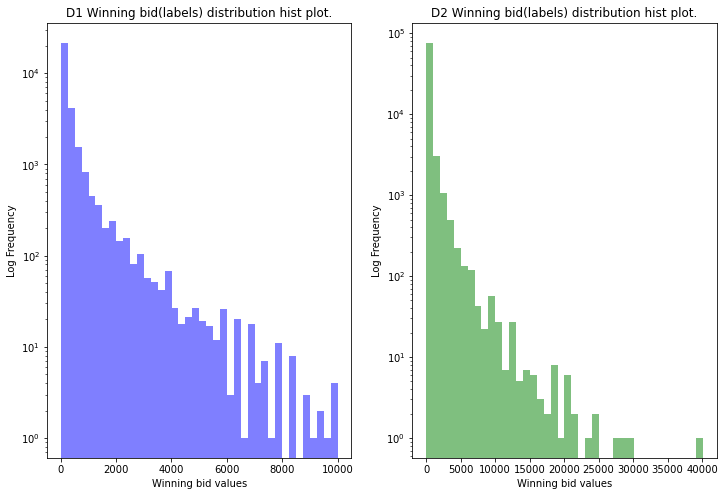

In [64]:
fig,axs = plt.subplots(1,2,figsize=(12,8))
# Generate some sample data
data_a = d_a['Winning bid']
data_b = d_b['Winning bid']
axs[0].hist(data_a, bins=40, alpha=0.5, color='blue', log=True)
axs[1].hist(data_b, bins=40, alpha=0.5, color='green', log=True)
axs[0].set_title('D1 Winning bid(labels) distribution hist plot.')
axs[1].set_title('D2 Winning bid(labels) distribution hist plot.')
# Add labels and title
axs[0].set_xlabel('Winning bid values')
axs[0].set_ylabel('Log Frequency')
axs[1].set_xlabel('Winning bid values')
axs[1].set_ylabel('Log Frequency')
# Show the plot
plt.show()

In [74]:
set(d_a.columns) - set(cat_cols) - set(['his_bid_times','his_bid_prices'])

{'Winning bid',
 'age',
 'auc_year',
 'bottle number',
 'bottled',
 'cl',
 'distilled',
 'strength'}

In [75]:
set(d_b.columns) - set(cat_cols) - set(['his_bid_times','his_bid_prices','hist_ids'])

{'Winning bid',
 'age',
 'auc_year',
 'bottle number',
 'bottled',
 'cl',
 'distilled',
 'strength'}

In [154]:
d_b.columns

Index(['extracted_distillery', 'bottler label', 'distilled', 'bottled', 'age',
       'whisky type label', 'cask type', 'strength', 'cl', 'category',
       'his_bid_times', 'his_bid_prices', 'bottle number', 'Winning bid',
       'auc_year'],
      dtype='object')

In [151]:
'whisky type label' in cat_cols

True

extracted_distillery 0
0.7126063113650544
0.7697454527662594
bottler label 2
0.7847296123689651
whisky type label 3
0.9401000574902451
cask type 4
0.4350967064000263
0.9547294900492949
category 6
1.0


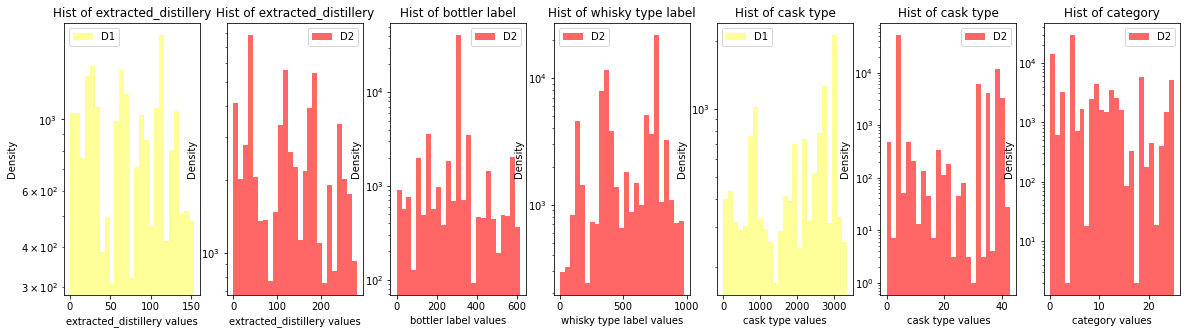

In [177]:
fig,axs = plt.subplots(1,7,figsize=(20,5))
idx = 0
for k in d_b.columns:
    if k not in cat_cols: continue
    if 'his_' in k: continue
    # if 'Winning' in k: continue
    print(k,idx)
    if k in d_a: 
        x = d_a[k]
        print(np.sum(x.notna())/x.shape[0])
        x = x.dropna().astype(int)
        ax = axs[idx%7]
        ax.hist(x, log=True, color='yellow' , alpha=0.4, bins=25,label='D1')
        idx += 1
        ax.set_title(f'Hist of {k}')
        ax.set_xlabel(f'{k} values')
        ax.set_ylabel('Density')
        ax.legend()
        
    ax = axs[idx%7]   
    y = d_b[k]
    # remove outlier values
    print(np.sum(y.notna())/y.shape[0])
    # Create a density plot with customized properties
    y = y.dropna().astype(int)
    ax.hist(y, log=True, color='red', alpha=0.6, bins=25,label='D2')
    # Add a title and axis labels
    ax.set_title(f'Hist of {k}')
    ax.set_xlabel(f'{k} values')
    ax.set_ylabel('Density')
    idx += 1
    ax.legend()

# plt.legend()
# Show the plot
plt.show()

1.0 1.0
0.693100843923423 0.5750614656342886
0.485338061931501 0.3085758320795567
0.44383147801530226 0.396340195466833
0.4931862213903392 0.42007021149070983
0.912586608872689 0.938473205876237
0.9125537713854136 0.9469499590229105
1.0 1.0


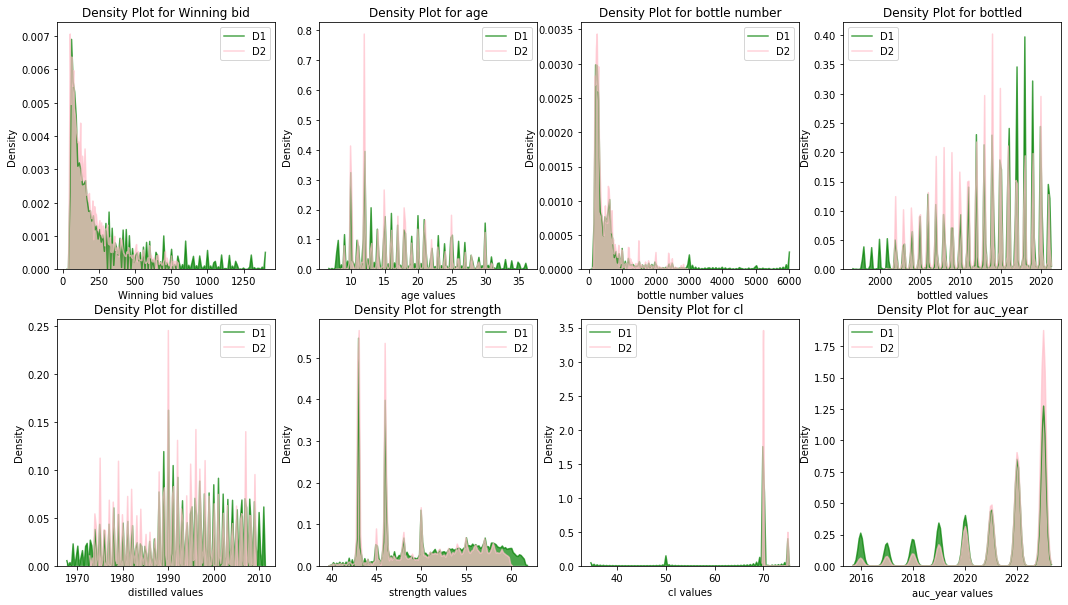

In [143]:
import seaborn as sns
fig,axs = plt.subplots(2,4,figsize=(18,10))
idx = 0
for k in d_a.columns:
    if k in cat_cols: continue
    if 'his' in k: continue
    # if 'Winning' in k: continue
    ax = axs[idx//4][idx%4]
    x,y = d_a[k],d_b[k]
    # remove outlier values
    print(np.sum(x.notna())/x.shape[0],np.sum(y.notna())/y.shape[0])
    # Create a density plot with customized properties
    x,y = x.dropna(),y.dropna()
    lower_cutoff,upper_cutoff = np.percentile(x,[5,95])
    x = x[(x >= lower_cutoff) & (x <= upper_cutoff)]
    lower_cutoff,upper_cutoff = np.percentile(x,[5,95])
    y = y[(y >= lower_cutoff) & (y <= upper_cutoff)]
    # ax.hist(x, density=True, color='green', alpha=0.7, bins=25,label='D1')
    # ax.hist(y, density=True, color='pink', alpha=0.7, bins=25,label='D2')
    sns.kdeplot(x, shade=True, color="g", label="D1", alpha=.7,ax=ax,bw=0.1)
    sns.kdeplot(y, shade=True, color="pink", label="D2", alpha=.7,ax=ax,bw=0.1)
    # Add a title and axis labels
    ax.set_title(f'Density Plot for {k}')
    ax.set_xlabel(f'{k} values')
    ax.set_ylabel('Density')
    idx += 1

# plt.legend()
# Show the plot
plt.show()

In [161]:
d_b['cask type']

0         5.0
1        32.0
2        36.0
3         4.0
4         5.0
         ... 
81748     4.0
81749     NaN
81750     4.0
81751    39.0
81752     5.0
Name: cask type, Length: 81753, dtype: float64

In [119]:
y.min(),y.max(),y.mean(),y.shape

(70.0, 75.0, 70.62424117707583, (38876,))

In [120]:
np.bincount(y)[-10:]

array([    0,     0,     0,     0, 34011,     9,     5,     3,     0,
        4848])

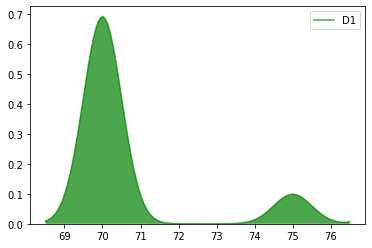

In [132]:
sns.kdeplot(y, shade=True, color="g", label="D1", alpha=.7,gridsize=100,bw=0.5)
plt.show()